In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch
from model import build_model
import tqdm
from data import load_data
import matplotlib.pyplot as plt



In [4]:
from model import Generator, Descriminator
generator = Generator(latent_dim=256)
descriminator = Descriminator()

In [5]:
generator

Generator(
  (seq_pipe): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(1, 1))
    (10): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(1, 1))
    (13): Sigmoid()
  )
)

In [6]:
descriminator

Descriminator(
  (descriminator): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(128, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=64, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=64, out_features=32, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=32, out_features=1, bias=True)
    (15): Sigmoid()
  )
)

In [17]:
def evaluate(generator: Generator, descriminator: Descriminator, test_loader, num_data, batch_size, device):
    generator.eval()
    descriminator.eval()
    progress_bar = tqdm.tqdm(test_loader)
    generator_losses = []
    descriminator_losses = []
    for i, (images, _) in enumerate(progress_bar):
      with torch.no_grad():
          real_img_batch = images.to(device)
          fake_img_batch = generator(batch_size)
            
          real_labels = torch.ones(size=(batch_size, ), device=device)
          fake_labels = torch.zeros(size=(batch_size, ), device=device)
            
          # Descriminate
          real_desc_pred = descriminator(real_img_batch).squeeze() # (5, 1)
          fake_desc_pred = descriminator(fake_img_batch).squeeze() # Descrimating Generated image
            
          real_desc_loss = F.binary_cross_entropy(real_desc_pred, real_labels)
          fake_desc_loss = F.binary_cross_entropy(fake_desc_pred, fake_labels)
          descriminator_loss = (real_desc_loss + fake_desc_loss) / 2.0
          
          fake_img_batch = generator(batch_size)
          fake_desc_pred = descriminator(fake_img_batch).squeeze()
          generator_loss = F.binary_cross_entropy(fake_desc_pred, real_labels)
          
          generator_losses.append(generator_loss.item())
          descriminator_losses.append(descriminator_loss.item())
          
      if i == num_data:
          break
    
    eval_generator_mean_loss = torch.tensor(generator_losses).mean()
    eval_descriminator_mean_loss = torch.tensor(descriminator_losses).mean()
    
    img = generator(1).squeeze().detach().cpu()
    plt.imshow(img, cmap='gray')
    plt.title("Generated Image")
    plt.axis("off")
    plt.show()
    
    generator.train()
    descriminator.train()
    
    return eval_descriminator_mean_loss, eval_generator_mean_loss
 
def train(generator, descriminator, num_epochs, eval_epoch, device, batch_size):
    generator.to(device)
    descriminator.to(device)
    descriminator_optimizer = torch.optim.AdamW(descriminator.parameters(), lr=1e-4)
    generator_optimizer = torch.optim.AdamW(generator.parameters(), lr=1e-4)
    train_loader, test_loader = load_data(train_batch_size=batch_size, test_batch_size=2)
    
    
    for epoch in range(num_epochs):
        progress = tqdm.tqdm(train_loader, dynamic_ncols=True)
        generator.train()
        descriminator.train()
        progress.set_description(f'Epoch: {epoch}')
        generator_losses = []
        descriminator_losses = []
        
        for images, _ in progress:
            real_img_batch = images.to(device)
            fake_img_batch = generator(batch_size)
            
            real_labels = torch.ones(size=(batch_size, ), device=device)
            fake_labels = torch.zeros(size=(batch_size, ), device=device)
            
            # Descriminate
            real_desc_pred = descriminator(real_img_batch).squeeze() # (5, 1)
            fake_desc_pred = descriminator(fake_img_batch).squeeze() # Descrimating Generated image
            
            real_desc_loss = F.binary_cross_entropy(real_desc_pred, real_labels)
            fake_desc_loss = F.binary_cross_entropy(fake_desc_pred, fake_labels)
            descriminator_loss = (real_desc_loss + fake_desc_loss) / 2.0
        
            descriminator_loss.backward()
            descriminator_optimizer.step()
            descriminator_optimizer.zero_grad()
            
            fake_img_batch = generator(batch_size)
            fake_desc_pred = descriminator(fake_img_batch).squeeze()
            generator_loss = F.binary_cross_entropy(fake_desc_pred, real_labels)
            generator_loss.backward()
            generator_optimizer.step()
            generator_optimizer.zero_grad()
            
            generator_losses.append(generator_loss.item())
            descriminator_losses.append(descriminator_loss.item())
            
            progress.set_postfix({'generator_loss': generator_loss.item(), 'descriminator_loss': descriminator_loss.item()})
            
      
        generator_mean_loss = torch.tensor(generator_losses).mean()
        descriminator_mean_loss = torch.tensor(descriminator_losses).mean()
       
        if epoch > 1 :
          eval_descriminator_loss, eval_generator_loss = evaluate(generator, descriminator,test_loader, num_data=20, batch_size=2, device='cuda')
          progress.set_postfix({'generator_loss': generator_mean_loss, 'descriminator_loss': descriminator_mean_loss, 'eval_gen_loss': eval_generator_loss, 'eval_des_loss':eval_descriminator_loss})
        else:
         progress.set_postfix({'generator_loss': generator_mean_loss, 'descriminator_loss': descriminator_mean_loss})
       
      
          
    

In [24]:
def evaluate(generator: Generator, discriminator: Descriminator, test_loader, num_data, batch_size, device):
    generator.eval()
    discriminator.eval()
    progress_bar = tqdm.tqdm(test_loader)
    generator_losses = []
    discriminator_losses = []
    for i, (images, _) in enumerate(progress_bar):
        with torch.no_grad():
            real_img_batch = images.to(device)
            fake_img_batch = generator(batch_size)
            
            real_labels = torch.ones(size=(batch_size, ), device=device)
            fake_labels = torch.zeros(size=(batch_size, ), device=device)
            
            # Discriminate
            real_desc_pred = discriminator(real_img_batch).squeeze()
            fake_desc_pred = discriminator(fake_img_batch).squeeze()
            
            real_desc_loss = F.binary_cross_entropy_with_logits(real_desc_pred, real_labels)
            fake_desc_loss = F.binary_cross_entropy_with_logits(fake_desc_pred, fake_labels)
            discriminator_loss = (real_desc_loss + fake_desc_loss) / 2.0
            
            # Generator evaluation
            fake_img_batch = generator(batch_size)
            fake_desc_pred = discriminator(fake_img_batch).squeeze()
            generator_loss = F.binary_cross_entropy_with_logits(fake_desc_pred, real_labels)
            
            generator_losses.append(generator_loss.item())
            discriminator_losses.append(discriminator_loss.item())
            
        if i >= num_data:  # Use >= instead of ==
            break
    
    eval_generator_mean_loss = torch.tensor(generator_losses).mean()
    eval_discriminator_mean_loss = torch.tensor(discriminator_losses).mean()
    
    img = generator(1).squeeze().detach().cpu()
    plt.imshow(img, cmap='gray')
    plt.title("Generated Image")
    plt.axis("off")
    plt.show()
    
    generator.train()
    discriminator.train()
    
    return eval_discriminator_mean_loss, eval_generator_mean_loss

def train(generator, discriminator, num_epochs, eval_epoch, device, batch_size):
    generator.to(device)
    discriminator.to(device)
    
    # Different learning rates - often helps with stability
    discriminator_optimizer = torch.optim.AdamW(discriminator.parameters(), lr=5e-4, betas=(0.5, 0.999))
    generator_optimizer = torch.optim.AdamW(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
    
    train_loader, test_loader = load_data(train_batch_size=batch_size, test_batch_size=2)
    
    for epoch in range(num_epochs):
        progress = tqdm.tqdm(train_loader, dynamic_ncols=True)
        generator.train()
        discriminator.train()
        progress.set_description(f'Epoch: {epoch}')
        generator_losses = []
        discriminator_losses = []
        
        for images, _ in progress:
            real_img_batch = images.to(device)
            batch_size_actual = real_img_batch.size(0)  # Handle variable batch sizes
            
            real_labels = torch.ones(size=(batch_size_actual,), device=device) + 0.3 * torch.randn(size=(batch_size_actual,), device=device)
            fake_labels = torch.zeros(size=(batch_size_actual,), device=device) - 0.3 * torch.randn(size=(batch_size_actual,), device=device)
            
            # === Train Discriminator ===
            discriminator_optimizer.zero_grad()
            
            # Real images
            real_desc_pred = discriminator(real_img_batch).squeeze()
            real_desc_loss = F.binary_cross_entropy_with_logits(real_desc_pred, real_labels)
            
            # Fake images (detach to prevent generator gradients)
            fake_img_batch = generator(batch_size_actual).detach()  # DETACH HERE
            fake_desc_pred = discriminator(fake_img_batch).squeeze()
            fake_desc_loss = F.binary_cross_entropy_with_logits(fake_desc_pred, fake_labels)
            
            discriminator_loss = (real_desc_loss + fake_desc_loss) / 2.0
            discriminator_loss.backward()
            discriminator_optimizer.step()
            
            # === Train Generator ===
            generator_optimizer.zero_grad()
            
            # Generate new fake images (don't detach - we want gradients)
            fake_img_batch = generator(batch_size_actual)
            fake_desc_pred = discriminator(fake_img_batch).squeeze()
            generator_loss = F.binary_cross_entropy_with_logits(fake_desc_pred, real_labels)
            
            generator_loss.backward()
            generator_optimizer.step()
            
            generator_losses.append(generator_loss.item())
            discriminator_losses.append(discriminator_loss.item())
            
            progress.set_postfix({
                'gen_loss': f"{generator_loss.item():.4f}", 
                'disc_loss': f"{discriminator_loss.item():.4f}"
            })
        
        generator_mean_loss = torch.tensor(generator_losses).mean()
        discriminator_mean_loss = torch.tensor(discriminator_losses).mean()
        
        if epoch > 1:
            eval_discriminator_loss, eval_generator_loss = evaluate(
                generator, discriminator, test_loader, num_data=20, batch_size=2, device=device
            )
            progress.set_postfix({
                'gen_loss': f"{generator_mean_loss:.4f}", 
                'disc_loss': f"{discriminator_mean_loss:.4f}", 
                'eval_gen': f"{eval_generator_loss:.4f}", 
                'eval_disc': f"{eval_discriminator_loss:.4f}"
            })
        else:
            progress.set_postfix({
                'gen_loss': f"{generator_mean_loss:.4f}", 
                'disc_loss': f"{discriminator_mean_loss:.4f}"
            })

  0%|          | 20/5000 [00:00<00:22, 217.29it/s]


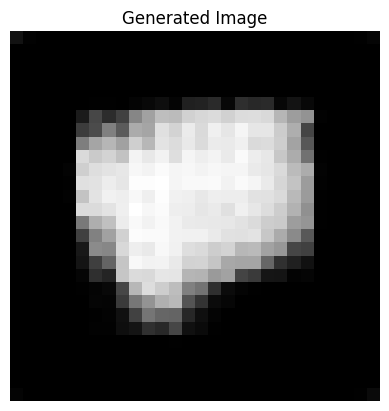

Epoch: 3:  28%|██▊       | 532/1875 [00:10<00:25, 52.14it/s, gen_loss=0.6931, disc_loss=0.5066]


KeyboardInterrupt: 

In [25]:
train(generator=generator, discriminator=descriminator, num_epochs=100, eval_epoch=20, device='cuda', batch_size=32)